# Graph Data Science for Supply Chain: Part III
## Path Finding, Optimization, and Recommendation for Supply Chain and Logistics

This notebook covers the use of GDS to find shortest routes and feed downstreem optimization and recommendation for logistics and supply chain networks.


For a sample dataset we will use the “Cargo 2000” transport and logistics case study [[1]](#1). Cargo 2000 (re-branded as Cargo iQ in 2016) is an initiative of the International Air Transport Association (IATA) that aims to deliver a new quality management system for the air cargo industry.logistics-diagram.png

The below figure shows a model of the business processes covered in the IATA case study. It represents the business processes of a freight forwarding company, in which up to three smaller shipments from suppliers are consolidated and then shipped together to customers. The business process is structured into incoming and outgoing transport legs, with the overall objective that freight is delivered to customers in a timely manner.  You can find out more about the business model in the [first blog of this series](https://neo4j.com/developer-blog/supply-chain-neo4j-gds-bloom/) where we explored the dataset in Neo4j Bloom or from the [original data source]( https://s-cube-network.eu/c2k/).

<img src="img/logistics-diagram.png" alt="summary" width="1000"/>


## Prerequisites
- Neo4j >= 4.3
- GDS >= 2.0
- The Cargo 2000 case study dataset loaded into a Neo4j database. There is a notebook to generate the Neo4j database [here](https://github.com/neo4j-product-examples/demo-supply-chain-logistics/blob/main/airplane-cargo/part1/transform-and-load.ipynb).

## References
<a id="1">[1]</a> A. Metzger, P. Leitner, D. Ivanovic, E. Schmieders, R. Franklin, M. Carro, S. Dustdar, and K. Pohl, “ Comparing and combining predictive business process monitoring techniques,” IEEE Trans. on Systems Man Cybernetics: Systems, 2015.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ds_utils

In [2]:
from graphdatascience import GraphDataScience

# Use Neo4j URI and credentials according to your setup
gds = GraphDataScience('neo4j://localhost', auth=('neo4j', 'neo'))

## Understanding Historic Shipments
In the last two parts of this series we have primarily worked with a collapsed form of the network using the SENDS_TO relationship.  In this part, since we are concerned with specific routes, we will work with the full data model depicted below.

<img src="img/c2k-schema.png" alt="summary" width="1000"/>


With this data model it is fairly simple to pull the distribution of total minutes for historic shipment legs with Cypher.  Below is a distribution of total time for legs going from Moodytown to Davisfort, one of the most common routes.  You can see the [notebook] if you are interested in understanding the Cypher query used.

In [3]:
# Calculate distribution for a single path
source_airport_id = 815 #'Moodytown'
target_airport_id = 700 #'Davisfort'
moodytown_davisfort_df = gds.run_cypher('''
    //match incoming legIds (leg numbers are > 0)
    MATCH(:EntryPoint {airportId: $sourceAirportId})-[r:RECEPTION]->() WHERE r.legNumber > 0
    WITH r.legId AS incomingLegId, r.shipmentId AS shipmentId
    //filter to only shipmentIds that go to target airport
    MATCH()-[:DELIVERY {shipmentId:shipmentId}]->(:Destination {airportId: $targetAirportId})
    WITH incomingLegId, shipmentId
    //incoming relationships
    MATCH()-[r {legId: incomingLegId}]->()
    WITH incomingLegId, shipmentId, sum(r.effectiveMinutes) AS incomingMinutes
    //outgoing relationships (leg numbers are < 0)
    MATCH()-[r {shipmentId: shipmentId}]->() WHERE r.legNumber < 0
    WITH incomingLegId, r.legId AS outgoingLegId, shipmentId, incomingMinutes, sum(r.effectiveMinutes) AS outgoingMinutes
    //sum all results on return
    RETURN incomingLegId, outgoingLegId, shipmentId, incomingMinutes, outgoingMinutes, (incomingMinutes + outgoingMinutes) AS totalMinutes
    ORDER BY incomingLegId
''', params = {'sourceAirportId': source_airport_id, 'targetAirportId': target_airport_id})
moodytown_davisfort_df

,incomingLegId,outgoingLegId,shipmentId,incomingMinutes,outgoingMinutes,totalMinutes
0,123,8502,1490,1292,3698,4990
1,1430,8403,1067,6235,9926,16161
2,2601,657,1145,7592,5359,12951
3,2617,14366,605,1117,2161,3278
4,2941,7910,1323,1902,1612,3514
...,...,...,...,...,...,...
79,10934,6792,2633,553,6514,7067
80,10942,7971,1267,2630,2377,5007
81,11019,14532,160,722,4305,5027
82,11127,6299,3167,3486,1734,5220


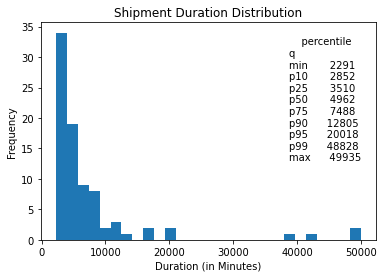

Mean Duration: 7741.5


In [4]:
def get_percentiles(s, q=None):
    if q is None:
        q = [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
    q_name = ['min'] + [f'p{int(100*i)}' for i in q] + ['max']
    p = [s.min()] + [round(s.quantile(i)) for i in q] + [s.max()]
    p_df = pd.DataFrame(np.column_stack((q_name, p)), columns=['q', 'percentile'])
    return p_df.set_index('q')

plt.hist(moodytown_davisfort_df.totalMinutes, bins=max(round(moodytown_davisfort_df.shape[0]/3),5))
plt.title('Shipment Duration Distribution')
plt.ylabel('Frequency')
plt.xlabel('Duration (in Minutes)')
plt.figtext(0.7, 0.4, get_percentiles(moodytown_davisfort_df.totalMinutes).to_string())
plt.show()
print(f'Mean Duration: {round(moodytown_davisfort_df.totalMinutes.mean(),1)}')

## Find Shortest Routes with GDS Path Finding

In [8]:
g, _ = gds.graph.project.cypher('proj',
    '''
   MATCH(n)
   WHERE n:EntryPoint OR n:DepartureWarehouse OR n:DeparturePoint OR n:ArrivalWarehouse OR n:TransferPoint OR n:Destination
   RETURN id(n) as id, labels(n) as labels
   '''
    ,
    '''
    MATCH(n0)-[r:RECEPTION|DEPARTURE|TRANSPORT|DELIVERY]->(n1)
    RETURN id(n0) AS source, id(n1) AS target, type(r) AS type, avg(r.effectiveMinutes) AS averageEffectiveMinutes
    '''
)
_

nodeQuery            MATCH(n)\n   WHERE n:EntryPoint OR n:Departure...
relationshipQuery    MATCH(n0)-[r:RECEPTION|DEPARTURE|TRANSPORT|DEL...
graphName                                                         proj
nodeCount                                                         1422
relationshipCount                                                 2024
projectMillis                                                       41
Name: 0, dtype: object

In [9]:
source_airport_name = 'Moodytown'
target_airport_name = 'Davisfort'
source_node_id = gds.find_node_id(['EntryPoint'], {'name': source_airport_name})
target_node_id = gds.find_node_id(['Destination'], {'name': target_airport_name})
yen_df = gds.shortestPath.yens.stream(g, sourceNode=source_node_id, targetNode=target_node_id, k=15, relationshipWeightProperty='averageEffectiveMinutes')

In [10]:
def get_airport_names(p):
    return ' -> '.join(list(dict.fromkeys([node.get('name') for node in p.nodes])))
yen_df['airportPath'] = yen_df.path.apply(get_airport_names)
top_path_df = yen_df[['airportPath', 'totalCost']].rename(columns={'totalCost':'approximatedAvgCost'})
top_path_df

,airportPath,approximatedAvgCost
0,Moodytown -> Davisfort,3743.273964
1,Moodytown -> Michaelstad -> Davisfort,4409.658716
2,Moodytown -> Wandaborough -> Davisfort,4588.759270
3,Moodytown -> Matthewport -> Davisfort,4617.841660
4,Moodytown -> Bryanside -> Davisfort,4696.503596
5,Moodytown -> Shanefort -> Davisfort,4798.854341
6,Moodytown -> Langborough -> Davisfort,4861.601065
7,Moodytown -> Ramoshaven -> Wandaborough -> Dav...,5064.466587
8,Moodytown -> Wandaborough -> Michaelstad -> Da...,5167.685402
9,Moodytown -> Lisaton -> Michaelstad -> Davisfort,5274.477692


In [11]:
top_path_df.merge(ds_utils.historic_path_counts(gds, source_airport_id, target_airport_id), on='airportPath', how='outer')

,airportPath,approximatedAvgCost,historicPathCount,historicAvgCost,historicCostStd,historicCosts
0,Moodytown -> Davisfort,3743.273964,NaN,NaN,NaN,NaN
1,Moodytown -> Michaelstad -> Davisfort,4409.658716,48.0,4197.187500,1729.899538,"[5962, 2853, 2683, 3135, 4258, 3278, 2953, 286..."
2,Moodytown -> Wandaborough -> Davisfort,4588.759270,1.0,5007.000000,0.000000,[5007]
3,Moodytown -> Matthewport -> Davisfort,4617.841660,NaN,NaN,NaN,NaN
4,Moodytown -> Bryanside -> Davisfort,4696.503596,NaN,NaN,NaN,NaN
5,Moodytown -> Shanefort -> Davisfort,4798.854341,5.0,5768.000000,2057.876211,"[7522, 3379, 3754, 6549, 7636]"
6,Moodytown -> Langborough -> Davisfort,4861.601065,1.0,3514.000000,0.000000,[3514]
7,Moodytown -> Ramoshaven -> Wandaborough -> Dav...,5064.466587,NaN,NaN,NaN,NaN
8,Moodytown -> Wandaborough -> Michaelstad -> Da...,5167.685402,NaN,NaN,NaN,NaN
9,Moodytown -> Lisaton -> Michaelstad -> Davisfort,5274.477692,NaN,NaN,NaN,NaN


In [12]:
pd.options.display.width = 0
pd.options.display.max_colwidth = 0

target_node_id_2 = gds.find_node_id(['Destination'], {'name': 'Sandersshire'})

yen_df = gds.shortestPath.yens.stream(g, sourceNode=source_node_id, targetNode=target_node_id_2, k=15, relationshipWeightProperty='averageEffectiveMinutes')
yen_df['airportPath'] = yen_df.path.apply(get_airport_names)
top_path_df = yen_df[['airportPath', 'totalCost']].rename(columns={'totalCost':'approximatedAvgCost'})
top_path_df

,airportPath,approximatedAvgCost
0,Moodytown -> Shanefort -> Sandersshire,5208.344321
1,Moodytown -> Ramoshaven -> Shanefort -> Sandersshire,5715.502545
2,Moodytown -> Davisfort -> Sandersshire,5719.924774
3,Moodytown -> Michaelstad -> Shanefort -> Sandersshire,5912.069427
4,Moodytown -> Wandaborough -> Shanefort -> Sandersshire,6011.366366
5,Moodytown -> Richardberg -> Sandersshire,6087.670836
6,Moodytown -> Lisaton -> Shanefort -> Sandersshire,6120.390428
7,Moodytown -> Grayshire -> Shanefort -> Sandersshire,6215.389810
8,Moodytown -> Bryanside -> Brownberg -> Sandersshire,6348.892664
9,Moodytown -> Michaelstad -> Davisfort -> Sandersshire,6386.309525


In [13]:
# Calculate distribution for a single path
target_airport_id_2 = int(gds.run_cypher('MATCH(n) WHERE id(n) = $id RETURN n.airportId AS airportId', params={'id':target_node_id_2}).airportId[0])
top_path_df.merge(ds_utils.historic_path_counts(gds, source_airport_id, target_airport_id_2), on='airportPath', how='outer')

,airportPath,approximatedAvgCost,historicPathCount,historicAvgCost,historicCostStd,historicCosts
0,Moodytown -> Shanefort -> Sandersshire,5208.344321,NaN,NaN,NaN,NaN
1,Moodytown -> Ramoshaven -> Shanefort -> Sandersshire,5715.502545,NaN,NaN,NaN,NaN
2,Moodytown -> Davisfort -> Sandersshire,5719.924774,6.0,10146.166667,11521.556378,"[5003, 33616, 5033, 6419, 4562, 6244]"
3,Moodytown -> Michaelstad -> Shanefort -> Sandersshire,5912.069427,NaN,NaN,NaN,NaN
4,Moodytown -> Wandaborough -> Shanefort -> Sandersshire,6011.366366,NaN,NaN,NaN,NaN
5,Moodytown -> Richardberg -> Sandersshire,6087.670836,2.0,5407.000000,1422.698844,"[6413, 4401]"
6,Moodytown -> Lisaton -> Shanefort -> Sandersshire,6120.390428,1.0,5647.000000,0.000000,[5647]
7,Moodytown -> Grayshire -> Shanefort -> Sandersshire,6215.389810,NaN,NaN,NaN,NaN
8,Moodytown -> Bryanside -> Brownberg -> Sandersshire,6348.892664,8.0,6414.625000,1752.789934,"[5058, 6270, 6633, 4794, 7928, 5517, 5186, 9931]"
9,Moodytown -> Michaelstad -> Davisfort -> Sandersshire,6386.309525,NaN,NaN,NaN,NaN


## Freight Forwarding Combinations

In [14]:
source_airport_names =  ['Bradleymouth', 'Moodytown', 'Richardberg', 'Wandaborough']
target_airport_name = 'Sandersshire'

shortest_path_list = []
rels = {}
for source_airport_name in source_airport_names:
    source_node_id = gds.find_node_id(['EntryPoint'], {'name': source_airport_name})
    temp_df = gds.shortestPath.dijkstra.stream(g, sourceNode=source_node_id, targetNode=target_node_id_2, relationshipWeightProperty='averageEffectiveMinutes')
    for r in temp_df.path[0].relationships:
        rels[f'{r.start_node.id}-{r.end_node.id}'] = r

print(f'Total Average Cost: {round(sum([r.get("cost") for r in rels.values()]), 2)}')

Total Average Cost: 15805.44


In [15]:
ds_utils.write_solution_to_db(gds, rels.values(), 'BEST_PATHS')

<img src="img/sandersshire-all-shortest-paths.png" alt="summary" width="1000"/>

### Freight Forwarding Solution Using Minimal Cost Objective

In [16]:
top_k_df = ds_utils.top_k_solutions_from_names(gds, g, source_airport_names, target_airport_name).rename(columns={'totalCost':'totalAverageTime'})
top_k_df[['solutionIndex', 'totalAverageTime', 'pathCosts']]

,solutionIndex,totalAverageTime,pathCosts
0,"(1, 0, 1, 0)",14069.456562,"[6221.733971695967, 5208.344320769946, 6535.08500916388, 4349.129699336236]"
1,"(1, 1, 1, 0)",14576.614786,"[6221.733971695967, 5715.5025446598775, 6535.08500916388, 4349.129699336236]"
2,"(1, 0, 1, 2)",14640.372950,"[6221.733971695967, 5208.344320769946, 6535.08500916388, 4920.046087296103]"
3,"(1, 4, 1, 0)",14668.587302,"[6221.733971695967, 6011.366365614366, 6535.08500916388, 4349.129699336236]"
4,"(1, 1, 1, 2)",14715.954250,"[6221.733971695967, 5715.5025446598775, 6535.08500916388, 4920.046087296103]"
5,"(1, 0, 1, 3)",14728.186310,"[6221.733971695967, 5208.344320769946, 6535.08500916388, 5007.859447619989]"
6,"(1, 3, 1, 0)",14773.181668,"[6221.733971695967, 5912.069427455579, 6535.08500916388, 4349.129699336236]"
7,"(1, 3, 1, 3)",14775.490364,"[6221.733971695967, 5912.069427455579, 6535.08500916388, 5007.859447619989]"
8,"(1, 0, 0, 0)",14803.355023,"[6221.733971695967, 5208.344320769946, 5629.324222812856, 4349.129699336236]"
9,"(1, 0, 1, 4)",14853.769859,"[6221.733971695967, 5208.344320769946, 6535.08500916388, 5133.442996838174]"


In [17]:
ds_utils.write_solution_to_db(gds, top_k_df.relationships[0], 'BEST_YENS_PATH')

<img src="img/sandersshire-best-yens.png" alt="summary" width="1000"/>

### Applying Constraints

In [18]:
top_k_df = ds_utils.top_k_solutions_from_names(gds, g, source_airport_names, target_airport_name, max_avg_time=6000.0)\
    .rename(columns={'totalCost':'totalAverageTime'})
top_k_df[['solutionIndex', 'totalAverageTime', 'pathCosts']]

,solutionIndex,totalAverageTime,pathCosts
0,"(0, 0, 0, 0)",15805.435025,"[5584.15472555134, 5208.344320769946, 5629.324222812856, 4349.129699336236]"
1,"(0, 2, 0, 1)",15881.873342,"[5584.15472555134, 5719.924774003627, 5629.324222812856, 4903.173413290249]"
2,"(0, 1, 0, 0)",16312.593249,"[5584.15472555134, 5715.5025446598775, 5629.324222812856, 4349.129699336236]"
3,"(0, 0, 0, 2)",16376.351413,"[5584.15472555134, 5208.344320769946, 5629.324222812856, 4920.046087296103]"
4,"(0, 1, 0, 2)",16451.932714,"[5584.15472555134, 5715.5025446598775, 5629.324222812856, 4920.046087296103]"
5,"(0, 2, 0, 8)",16460.799474,"[5584.15472555134, 5719.924774003627, 5629.324222812856, 5482.099545580897]"
6,"(0, 0, 0, 3)",16464.164773,"[5584.15472555134, 5208.344320769946, 5629.324222812856, 5007.859447619989]"
7,"(0, 3, 0, 0)",16509.160132,"[5584.15472555134, 5912.069427455579, 5629.324222812856, 4349.129699336236]"
8,"(0, 3, 0, 3)",16511.468827,"[5584.15472555134, 5912.069427455579, 5629.324222812856, 5007.859447619989]"
9,"(0, 0, 0, 4)",16589.748322,"[5584.15472555134, 5208.344320769946, 5629.324222812856, 5133.442996838174]"


In [19]:
ds_utils.write_solution_to_db(gds, top_k_df.relationships[0], 'BEST_YENS_PATH')

<img src="img/sandersshire-all-shortest-paths.png" alt="summary" width="1000"/>

In [20]:
ds_utils.write_solution_to_db(gds, top_k_df.relationships[1], 'BEST_YENS_PATH')

<img src="img/sandersshire-second-best-yens-constrained.png" alt="summary" width="1000"/>

## What-If Scenarios and Path Finding

In [21]:
node_proj_query = '''
    MATCH(n)
    WHERE n:EntryPoint OR n:DepartureWarehouse OR n:DeparturePoint OR n:ArrivalWarehouse OR n:TransferPoint OR n:Destination
    RETURN id(n) as id, labels(n) as labels
    '''

relationship_proj_query =  '''
    MATCH(n0)-[r:RECEPTION|DEPARTURE|TRANSPORT|DELIVERY]->(n1)
    RETURN id(n0) AS source, id(n1) AS target, type(r) AS type,
        CASE
            WHEN n1.name in $delayAirportNames THEN $delayMultiplier * avg(r.effectiveMinutes)
            ELSE avg(r.effectiveMinutes)
            END AS averageEffectiveMinutes
    '''

In [25]:
g.drop()
g, _ = gds.graph.project.cypher('proj', node_proj_query, relationship_proj_query
    , parameters = {'delayAirportNames': ['Shanefort'], 'delayMultiplier': 3.0})

top_k_df = ds_utils.top_k_solutions_from_names(gds, g, source_airport_names, target_airport_name).rename(columns={'totalCost':'totalAverageTime'})
ds_utils.write_solution_to_db(gds, top_k_df.relationships[0], 'BEST_YENS_PATH')
top_k_df[['solutionIndex', 'totalAverageTime', 'pathCosts']]

,solutionIndex,totalAverageTime,pathCosts
0,"(0, 5, 4, 0)",15227.326930,"[5584.15472555134, 6565.410079568379, 8208.315245760938, 4903.173413290248]"
1,"(1, 1, 0, 4)",15316.952203,"[7078.438011342081, 6087.670836006222, 5629.324222812856, 5486.420465780242]"
2,"(1, 7, 0, 7)",15433.867368,"[7078.438011342081, 6633.386001171387, 5629.324222812856, 5729.1760213357975]"
3,"(1, 1, 0, 7)",15559.707758,"[7078.438011342081, 6087.670836006222, 5629.324222812856, 5729.1760213357975]"
4,"(0, 3, 9, 2)",15575.926376,"[5584.15472555134, 6386.309525416487, 8304.28462129483, 5482.099545580897]"
5,"(1, 9, 0, 8)",15613.565653,"[7078.438011342081, 6821.68428629862, 5629.324222812856, 5824.0204657802415]"
6,"(0, 5, 2, 0)",15627.676930,"[5584.15472555134, 6565.410079568379, 6927.236771832464, 4903.173413290248]"
7,"(0, 5, 0, 0)",15644.186930,"[5584.15472555134, 6565.410079568379, 5629.324222812856, 4903.173413290248]"
8,"(1, 1, 0, 8)",15654.552203,"[7078.438011342081, 6087.670836006222, 5629.324222812856, 5824.0204657802415]"
9,"(0, 3, 2, 2)",15654.776376,"[5584.15472555134, 6386.309525416487, 6927.236771832464, 5482.099545580897]"


<img src="img/sandersshire-best-yens-delayed-1.png" alt="summary" width="1000"/>

In [26]:
g.drop()
g, _ = gds.graph.project.cypher('proj', node_proj_query, relationship_proj_query
                                , parameters = {'delayAirportNames': ['Shanefort', 'Davisfort', 'Richardberg'], 'delayMultiplier': 3.0})

top_k_df = ds_utils.top_k_solutions_from_names(gds, g, source_airport_names, target_airport_name).rename(columns={'totalCost':'totalAverageTime'})
ds_utils.write_solution_to_db(gds, top_k_df.relationships[0], 'BEST_YENS_PATH')
top_k_df[['solutionIndex', 'totalAverageTime', 'pathCosts']]

,solutionIndex,totalAverageTime,pathCosts
0,"(0, 0, 1, 0)",27324.638407,"[9003.383694558299, 6348.8926636941715, 14058.680579496433, 5351.228843175793]"
1,"(0, 1, 1, 1)",27371.266645,"[9003.383694558299, 6386.9209015184615, 14058.680579496433, 5482.710921682872]"
2,"(0, 2, 2, 2)",27412.482172,"[9003.383694558299, 6848.581630429191, 15413.526286028708, 5898.309037980989]"
3,"(0, 1, 3, 1)",27456.878586,"[9003.383694558299, 6386.9209015184615, 15451.585312587733, 5482.710921682872]"
4,"(0, 0, 0, 0)",27505.610348,"[9003.383694558299, 6348.8926636941715, 12776.013538003786, 5351.228843175793]"
5,"(0, 1, 0, 1)",27552.238586,"[9003.383694558299, 6386.9209015184615, 12776.013538003786, 5482.710921682872]"
6,"(0, 3, 6, 0)",27555.723193,"[9003.383694558299, 7013.465509453924, 15803.059990837412, 5351.228843175793]"
7,"(0, 0, 6, 0)",27687.007104,"[9003.383694558299, 6348.8926636941715, 15803.059990837412, 5351.228843175793]"
8,"(0, 5, 4, 3)",27787.323118,"[9003.383694558299, 7109.06543398196, 15585.125853128273, 5913.551462223413]"
9,"(0, 3, 1, 0)",27791.611253,"[9003.383694558299, 7013.465509453924, 14058.680579496433, 5351.228843175793]"


<img src="img/sandersshire-best-yens-delayed-2.png" alt="summary" width="1000"/>

In [24]:
# Cleanup: remove paths and graph projection
ds_utils.remove_solution_from_db(gds, 'BEST_PATHS')
ds_utils.remove_solution_from_db(gds, 'BEST_YENS_PATH')
ds_utils.clear_all_graphs(gds)